# Transmission line circuit



We consider the transmission line model used in [AKS11].
The RLC circuit of the transmission line is shown below.
In the circuit, ``U_{in}`` is the voltage at the sending end,
and ``U_{out}`` is the voltage at the receiving end.

![](https://raw.githubusercontent.com/JuliaReach/ReachabilityAnalysis.jl/master/examples/TransmissionLine/tline.png)

## Model description

For reference to understand this model we refer to any standard textbook on electrical circuits.
The electrical elements law for resistors (R), inductors (L) and capacitors (C) are studied,
for instance, in Chapter 3 of [^K15].

Let's assume that the network consists of ``η > 2`` nodes.
There are ``η`` dynamic equations for the capacitor voltages and ``\eta`` dynamic
equations for the circuit currents. Therefore, the state vector can be represented as

$$
x = [U_1, U_2, …, U_η, I_1, I_2, …, I_η]^T,
$$
and the state dimension is ``2η``.

**Analysis of the first node.** When writing the equations for the voltages and currents,
we should pay attention to the sign choices in given circuit, which do not exactly match
the convention in text-books (in the sense that ``U_1``s positive terminal is at the bottom,
as indicated by the arrows). Let ``R_d`` denote the driver resistance's current.
By Kirchhoff's voltage law,

$$
U_{in} = R_d I_1 + LI_1' - U_1,
$$
therefore
$$
\boxed{I_1' = \dfrac{U_{in} + U_1}{L} - \dfrac{R_d}{L}I_1}.
$$

By Kirchhoff's current law, and if ``I_{1, C}`` denotes the current through the
capacitor ``C``, connected to the first node,

$$
   I_1 = I_2 + I_{C, 1},
$$
and
$$
I_{C, 1} = -CU_1',
$$
then
$$
   \boxed{U_1' = \frac{I_2 - I_1}{C}}.
$$

**Analysis of the intermediate nodes.** Other node's equations are obtained
in a similar fashion. For instance, for the second loop one has

$$
-U_1 = RI_2 + LI_2' - U_2 \Rightarrow I_2' = \dfrac{U_2-U_1}{L} - \frac{R}{L}I_2
$$
for the current's equation, and

$$
   I_{2, C} = I_2 - I_3,\Rightarrow U_2' = \frac{I_3 - I_2}{C}.
$$
for the voltage's equation.

Generalizing for arbitrary ``l = 2, \ldots, \eta - 1`` is trivial and gives:

$$
    \boxed{I'_l = \dfrac{U_l - U_{l-1}}{L} - \frac{R}{L}I_l} \\
    \boxed{U'_l = \dfrac{I_{l+1} - I_l}{C}}.
$$

**Analysis of the last node.** The last node corresponds to the case ``l = \eta``

$$
\boxed{I'_\eta = \dfrac{U_\eta - U_{\eta-1}}{L} - \frac{R}{L}I_\eta}, \\
\boxed{U'_{out} = U'_{out} = - \frac{I_{\eta}}{C}}.
$$

**System of linear ODEs.** Recall that that the stateset is ``\mathbb{R}^{2\eta}``,
where the state variables are
``x = [U_1, U_2, \ldots, U_\eta, I_1, I_2, \ldots, I_\eta]^T``.
The system can be written as a block-diagonal system of linear ODEs,
$$
x'(t) = Ax(t) + BU_{in}(t),
$$
using the results in the previous section.

The coefficients matrix ``A`` can be written as a block-diagonal matrix.
There exist useful constructors in the base package `LinearAlgebra` that greatly simplify
building matrices with special shape, as in our case, such as diagonal and band matrices,
using the types `Diagonal` and `Bidiagonal` in our case.

In [1]:
using ReachabilityAnalysis, LinearAlgebra, SparseArrays

function tline(;η=3, R=1.00, Rd=10.0, L=1e-10, C=1e-13 * 4.00)
    A₁₁ = zeros(η, η)
    A₁₂ = Bidiagonal(fill(-1/C, η), fill(1/C, η-1), :U)
    A₂₁ = Bidiagonal(fill(1/L, η), fill(-1/L, η-1), :L)
    A₂₂ = Diagonal(vcat(-Rd/L, fill(-R/L, η-1)))
    A  = [A₁₁ A₁₂; A₂₁ A₂₂]
    B = sparse([η+1], [1], 1/L, 2η, 1)
    return A, B
end

tline (generic function with 1 method)

We can visualize the structure of the cofficients matrix ``A`` for the case
$\eta = 20$ with `spy` plot:

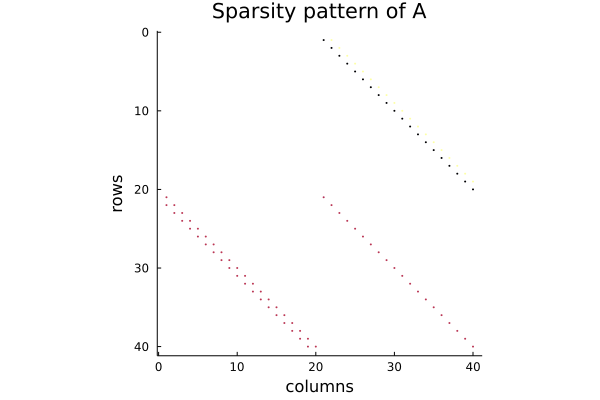

In [2]:
using Plots

A, _ = tline(η=20)
spy(A, legend=nothing, markersize=2.0, title="Sparsity pattern of A", xlab="columns", ylab="rows")

Notice that the matrix coefficients are rather big, hence it is convenient to rescale the system
for numerical stability.
Let ``α > 0`` be a scaling factor, and let ``\tilde{x}(t) = x(\alpha t)``.
By the chain rule,
$$
\tilde{x}'(t) = \alpha x'(\alpha t) = \alpha A x(\alpha t) + \alpha B U_{in}(\alpha t) = \tilde{A} \tilde{x}(t) + \tilde{B} \tilde{U}_{in}(t),
$$
where ``\tilde{A} := \alpha A`` and ``\tilde{B} := \alpha B``.

In [3]:
function scale!(s, α=1.0)
    s.A .*= α
    s.B .*= α
    return s
end

scale! (generic function with 2 methods)

Note that under this transformation, the time horizon has to be transformed as well,
through ``\tilde{T} = \alpha T``.

## Reachability settings

The transmission line parameters used in this model are displayed in the following table.

|resistance in [Ω] | driver resistance in [Ω] | Inductance in [H] | Capacitance in [F] |
|------------------|--------------------------|------------------|-------------------|
|R = 1.00| Rdriver = 10.0| L = 1e−10 | C = 4e−13|

The steady state is obtained by zeroing the left-hand side of the ODE, which gives

$$
   0 = x' = Ax_\infty + Bu_0 \Rightarrow x_\infty = -A^{-1}B u_0
$$
The initial set under consideration corresponds to the steady state for input voltages
``U_{in, ss} := [-0.2, 0.2]``.
Moreover, an uncertainty is added so that the initial currents are also uncertain.
The set of initial states is then
$$
   x(0) \in \mathcal{X}_0 := -A^{-1} B  U_{in, ss} \oplus □(0.001),
$$
where ``□(ϵ)`` is the infinity-norm ball of center zero and radius ``ϵ``.

The time horizon is chosen as ``T = 0.7`` seconds. We consider a
scaling factor ``\alpha = 1e-9``.

We are interested in the step response to an input voltage ``U_{in}(t)``, constant
for ``t \in [0, T]`` over the domain ``U_{in} = [0.99, 1.01]``.

We consider the case of ``\eta = 20`` nodes as in [AKS11], such that the system
has ``n = 40`` state variables.

In [4]:
η = 20 # order
n = 2η # state-space dimension
A, B = tline(η=η);

Uin_ss = Interval(-0.2, 0.2)
□(ϵ) = BallInf(zeros(n), ϵ)
X0 = -inv(Matrix(A)) * B * Uin_ss ⊕ □(0.001);

Uin = Interval(0.99, 1.01)
s = @system(x'= A*x + B*u, x ∈ Universe(n), u ∈ Uin)
α = 1e-9 # scaling factor
scale!(s, α);

T = 0.7 * 1e-11 # time horizon
P = InitialValueProblem(s, X0);

## Results

We solve system using a step size of `δ=1e-3` and the box algorithm.

In [5]:
sol = solve(P, T=0.7, alg=BOX(δ=1e-3));

To get the variable ``U_{out}`` we have to project onto the ``η``-th coordinate
and invert the sign of the flowpipe.

In [6]:
Uout_vs_t = @. (-1.0) * project(sol, η);

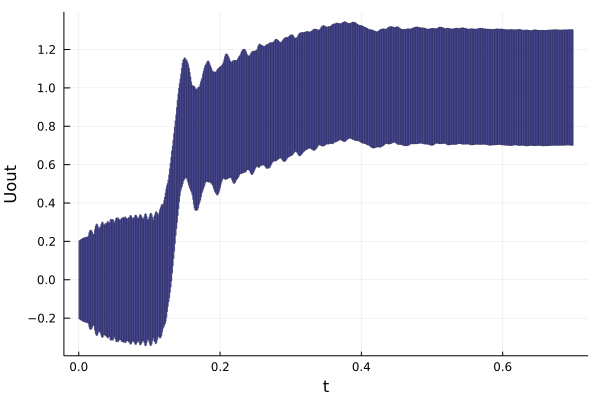

In [7]:
plot(Uout_vs_t, vars=(0, η), color=:blue, xlab="t", ylab="Uout", alpha=.5, lw=0.5)

## References

[^AKS11]: Althoff, Matthias, Bruce H. Krogh, and Olaf Stursberg. [Analyzing reachability of linear dynamic systems with parametric uncertainties.](http://www.i6.in.tum.de/Main/Publications/Althoff2011b.pdf). Modeling, Design, and Simulation of Systems with Uncertainties. Springer, Berlin, Heidelberg, 2011. 69-94.

[^K15]: Kluever, Craig A. [Dynamic systems: modeling, simulation, and control.](https://www.wiley.com/en-us/Dynamic+Systems%3A+Modeling%2C+Simulation%2C+and+Control-p-9781118289457). John Wiley & Sons, 2015.

[^GLG08]: Girard, Antoine, and Colas Le Guernic. [Efficient reachability analysis for linear systems using support functions.]() IFAC Proceedings Volumes 41.2 (2008): 8966-8971.